# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:** Vera Duong

---



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [2]:
class MDPLanding:
    def __init__(self, L, states, terminal_states, default_reward, all_actions, discount):
        self.states = states
        self.terminal_states = terminal_states
        self.default_reward = default_reward
        self.all_actions = all_actions
        self.discount = discount
        self.L = L
        
    def actions(self, state):
        actionsAvailable = []
        if state in self.terminal_states:
            return [None]
        if state[0] > 0:
            actionsAvailable.append('west')
        if state[0] < self.L:
            actionsAvailable.append('east')
        if state[1] > 0:
            actionsAvailable.append('south')
        if state[1] < self.L:
            actionsAvailable.append('north')
        if state[2] > 0:
            actionsAvailable.append('down')
        if state[2] < self.L:
            actionsAvailable.append('up')
        return actionsAvailable
            
    def reward(self, state): 
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward
                
    def result(self, state, action):
        newState = (0,0,0)
        if action == 'east':
            newState = (state[0] + 1, state[1], state[2])
        elif action == 'west':
            newState = (state[0] - 1, state[1], state[2])
        elif action == 'north':
            newState = (state[0], state[1] + 1, state[2])
        elif action == 'south':
            newState = (state[0], state[1] - 1, state[2])
        elif action == 'up':
            newState = (state[0], state[1], state[2] + 1)
        else: # down 
            newState = (state[0], state[1], state[2] - 1)
        return newState

In [3]:
# ------------------- Test when L=2 -------------------

states = []
terminal_states = {}
for i in range(3):
    for j in range(3):
        for k in range(3):
            states.append((i,j,k))
            if k == 0:
                terminal_states[(i,j,k)] = -1
terminal_states[(2,2,0)] = 1


testMdp = MDPLanding(2, states, terminal_states, -0.01, ['north','south','east','west','up','down'], 0.999)

print(testMdp.actions((0,1,0)))
print(testMdp.actions((0,2,1)))
print(testMdp.reward((1,1,0)))
print(testMdp.reward((1,1,1)))
print(testMdp.result((0,2,2), 'north'))
print(testMdp.result(testMdp.result((0,2,2), 'north'), 'east'))

[None]
['east', 'south', 'down', 'up']
-1
-0.01
(0, 3, 2)
(1, 3, 2)


#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [4]:
def policy_iter(MDP):
    
    actions = ['north','south','east','west','up','down'] 
    
    utilities = {}
    new_util = {}
    policies = {}
    
    stop = False
    
    # initialize utility for cube to 0
    for i in range(5):
        for j in range(5):
            for k in range(5):
                utilities[(i,j,k)] = 0
                
    for i in range(5):
        for j in range(5):
            for k in range(5):
                new_util[(i,j,k)] = 0
    
                
    # randomize all actions in cube            
    for i in range(5):
        for j in range(5):
            for k in range(5):
                randAct = np.random.choice(actions)
                policies[(i,j,k)] = randAct
                
    while stop == False:
                
        # Policy Evaluation 
        count = 0
        u_s = 0
        for state in MDP.states:
            if state[2] != 0: # when in the air
                if policies[state] in MDP.actions(state):
                    res = MDP.result(state, policies[state])
                    arg = 0.8*utilities[res] + 0.2*utilities[state]
                    u_s = MDP.reward(state) + MDP.discount * arg
                else: # stay in current spot when next action isn't avail
                    arg = utilities[state]
                    u_s = MDP.reward(state) + MDP.discount * arg
            elif state[2] == 0: # For the landing pad
                u_s = MDP.reward(state) 

            new_util[state] = u_s
    #         print(state, ": ", new_util[state])

        # Policy Improvement
        for state in MDP.states:
            best_util = -1000
            new_poli = ""

            if state[2] != 0:
                for act in MDP.actions(state):
                    if utilities[MDP.result(state, act)] > best_util:
                        best_util = utilities[MDP.result(state, act)]
                        new_poli = act
            policies[state] = new_poli
            
        for state in MDP.states:
            if abs(new_util[state] - utilities[state]) < 0.001:
                count += 1
        for state in MDP.states:
            utilities[state] = new_util[state]
            
        if count == 125:
            stop = True
            
    return policies  # return a dictionary with keys states -> action agent should take

In [5]:
states = []
for i in range(5):
    for j in range(5):
        for k in range(5):
            states.append((i,j,k))
            if k == 0:
                terminal_states[(i,j,k)] = -1
            
terminal_states[(2,2,0)] = 1

MDP = MDPLanding(4, states, terminal_states, -0.01, ['north','south','east','west','up','down'], 0.999)

policies = policy_iter(MDP)
print("Expected Policy for (4,2,1):", policies[(4,2,1)])
print("Expected Policy for (2,4,1):", policies[(2,4,1)])
print(" ")
print("Expected Policy for (2,2,1):", policies[(2,2,1)])
print("Expected Policy for (0,2,1):", policies[(0,2,1)])
print("Expected Policy for (2,0,1):", policies[(2,0,1)])
# print(policies)

Expected Policy for (4,2,1): west
Expected Policy for (2,4,1): south
 
Expected Policy for (2,2,1): down
Expected Policy for (0,2,1): east
Expected Policy for (2,0,1): north


#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [6]:
# ------------------------- Q-Learning -------------------------

def q_learn(MDP, trials):
    
    # ---------------------- initialize ----------------------
    
    actions = ['north','south','east','west','up','down']
    startLoc = [] # list of possible starting locations
    cum_rewards = []
    alpha = 0.1
    
    # starting locations
    for i in range(5):
        for j in range(5):
            for k in range(5):
                startLoc.append((i,j,k))
                if k == 0:
                    startLoc.remove((i,j,k))
    # q-values dictionary
    q_vals = dict([(state,dict([(action, 0) for action in MDP.actions(state)])) for state in MDP.states])    

    # ---------------------- Start Trials ----------------------      
            
    for trial in range(trials):
        total_rewards = 0
        inds = np.random.choice(len(startLoc))# start at random loc (not terminal)
        rand_start = startLoc[inds]
        s = rand_start

        for step in range(50):
            
            if s in MDP.terminal_states:
                total_rewards += MDP.discount**step*MDP.reward(s)
                q_vals[s][None] = total_rewards
                break
                
            else:
                # epsilon greedy
                if np.random.random() < 0.9: # if random value between 0 and 1 < epsilon -> exploit
                    if max(q_vals[s].values()) == 0:
                        a = MDP.actions(s)[np.random.randint(0,len(q_vals[s]))]
                    else:
                        a = max(q_vals[s], key=q_vals[s].get)
                else: # explore
                    a = np.random.choice(MDP.actions(s))

                sp = MDP.result(s, a)
                qsa = q_vals[s][a] 
                qapsp = max(q_vals[sp].values()) 
                new_qval = qsa + alpha*(MDP.reward(s) + (MDP.discount * qapsp) - qsa)
                q_vals[s][a] = new_qval
                total_rewards += MDP.discount**step*MDP.reward(s)
                s=sp
            
        cum_rewards.append(total_rewards)
            
    return q_vals, cum_rewards
                

In [23]:
MDP_q_4 = MDPLanding(4, states, terminal_states, -0.01, ['north','south','east','west','up','down'], 0.999)

print(q_learn(MDP_q_4,10000))

({(0, 0, 0): {None: -1.017991}, (0, 0, 1): {'east': 0.8786656390382744, 'north': 0.33928560337844815, 'down': -0.7419343308478082, 'up': 0.22383434093616872}, (0, 0, 2): {'east': 0.08108334481423604, 'north': 0.15710909404549805, 'down': 0.8619093747638178, 'up': 0.15642241577859872}, (0, 0, 3): {'east': 0.8432801131297389, 'north': 0.13661312368761963, 'down': 0.15448302435428127, 'up': 0.21939291288233076}, (0, 0, 4): {'east': 0.4027684251903324, 'north': 0.8329948876685944, 'down': 0.1225573357498039}, (0, 1, 0): {None: -1.009}, (0, 1, 1): {'east': 0.8774601632190592, 'south': 0.32711489110913056, 'north': 0.0815234384433953, 'down': -0.198262118321667, 'up': 0.14385547171253932}, (0, 1, 2): {'east': 0.08595964480059261, 'south': 0.20826545696284443, 'north': 0.8674864952783066, 'down': 0.08324768832811627, 'up': 0.15564831752349156}, (0, 1, 3): {'east': 0.8564363767474561, 'south': 0.23466171128631597, 'north': 0.1544174324962507, 'down': -0.00496531, 'up': 0.2790492890503464}, (0,

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

In [24]:
states = []
terminal_states = {}
for i in range(11):
    for j in range(11):
        for k in range(11):
            states.append((i,j,k))
            if k == 0:
                terminal_states[(i,j,k)] = -1
terminal_states[(2,2,0)] = 1

MDP_q_10 = MDPLanding(10, states, terminal_states, -0.01, ['north','south','east','west','up','down'], 0.999)

# print(q_learn(MDP_q_10,10000)[1])

In [31]:
# Your code here.
print("Mean cumulative reward of last 5,000 trials:",np.mean(q_learn(MDP_q_10,10000)[1][9500:]))

Mean cumulative reward of last 5,000 trials: 0.8654074276237786


In [32]:
# alpha = 0.1 - small blocks

block_means_small = []
learn = q_learn(MDP_q_10,1000)[1]
start = 0
end = 50
while end <= len(learn):
    block_means_small.append(np.mean(learn[start:end]))
    start += 50
    end += 50
    
block_means_small

[-0.8491757887014707,
 -0.7519904980562911,
 -0.6436736982269583,
 0.1209501358954418,
 0.3652305959915802,
 0.41678679130333185,
 0.5258250866194365,
 0.7773827610808695,
 0.8045085958292618,
 0.9018282896300518,
 0.6852110169027325,
 0.7640228173683604,
 0.7377699750433603,
 0.826181748884145,
 0.8524868915278412,
 0.8963263924279916,
 0.8693260195633569,
 0.8988249266971031,
 0.815249846452713,
 0.854169141876526]

In [33]:
# alpha = 0.0006 - large blocks

block_means = []
learn = q_learn(MDP_q_10,10000)[1]
start = 0
end = 500
while end <= len(learn):
    block_means.append(np.mean(learn[start:end]))
    start += 500
    end += 500
    
block_means

[0.4393239901068059,
 0.877109452443372,
 0.8938370178724822,
 0.9062000374052587,
 0.8826915585704358,
 0.9046058753395932,
 0.9176296854230843,
 0.90488859393649,
 0.8818778040210762,
 0.8942467326230017,
 0.8979259402132896,
 0.8845885774675875,
 0.8972190426357349,
 0.8869333538559062,
 0.8969172394355458,
 0.8841306622819299,
 0.8924989655404981,
 0.8658801540200245,
 0.9020227024211525,
 0.9055693420958728]

Text(0.5, 1.0, 'Average Result vs Block Number')

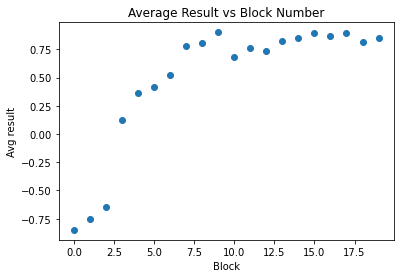

In [34]:
# small blocks

y = [i for i in range(len(block_means_small))]
plt.scatter(y, block_means_small)
plt.xlabel("Block")
plt.ylabel("Avg result")
plt.title("Average Result vs Block Number")

Text(0.5, 1.0, 'Average Result vs Block Number')

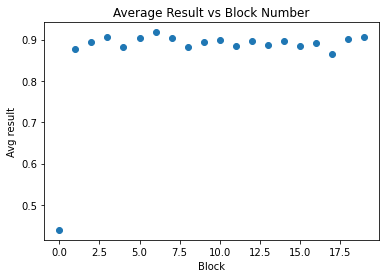

In [35]:
y = [i for i in range(len(block_means))]
plt.scatter(y, block_means)
plt.xlabel("Block")
plt.ylabel("Avg result")
plt.title("Average Result vs Block Number")

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

The cumulative reward starts off around -0.5 at the beginning of the training because the drone hasn't learned much in the first 500 trials. For example, the drone could hit a terminal state that's not the goal within 25 steps, the reward would be around -1.25. Another possibility is that the drone hits the goal within 25 steps. The cumulative reward here would be around 0.75. The average of these two would be greater than -0.5. However, there's more terminal states that aren't the goal compared to the one terminal state that is the goal, so we would weight the average in favor of -1.25 and that weighted average would give us something close to -0.5.

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

Due to the fact that we are looking at such a large environment with L=10, the drone has a higher chance of traveling down a path it has not visited in each trial. Since it is traveling down an unvisted path, it cannot train enough to find one with a higher resulting reward, which is why it is difficult for us to obtain rewards much greater than about 0.8. Furthermore, due to the epsilon in the greedy algorithm, the expected path is taken 90% of the time and the other 10% is responsible for traveling down the path that it hasn't visited before. Finally, there are 1,000 states so there's more chance that it will take more steps to reach the goal state.

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

In [14]:
# Class Structure #1

class MDP_S1:
    def __init__(self, L, states, terminal_states, default_reward, new_reward, all_actions, discount):
        self.states = states
        self.terminal_states = terminal_states
        self.default_reward = default_reward
        self.new_reward = new_reward
        self.all_actions = all_actions
        self.discount = discount
        self.L = L
        
    def actions(self, state):
        actionsAvailable = []
        if state in self.terminal_states:
            return [None]
        if state[0] > 0:
            actionsAvailable.append('west')
        if state[0] < self.L:
            actionsAvailable.append('east')
        if state[1] > 0:
            actionsAvailable.append('south')
        if state[1] < self.L:
            actionsAvailable.append('north')
        if state[2] > 0:
            actionsAvailable.append('down')
        if state[2] < self.L:
            actionsAvailable.append('up')
        return actionsAvailable
        
    def reward(self, state): # column above goal
        if state in self.terminal_states:
            return self.terminal_states[state]
        elif state[0] == 2 and state[1] == 2 and state[2] != 0:
            return self.new_reward
        else:
            return self.default_reward
                
    def result(self, state, action):
        newState = (0,0,0)
        if action == 'east':
            newState = (state[0] + 1, state[1], state[2])
        elif action == 'west':
            newState = (state[0] - 1, state[1], state[2])
        elif action == 'north':
            newState = (state[0], state[1] + 1, state[2])
        elif action == 'south':
            newState = (state[0], state[1] - 1, state[2])
        elif action == 'up':
            newState = (state[0], state[1], state[2] + 1)
        else: # down 
            newState = (state[0], state[1], state[2] - 1)
        return newState

In [15]:
# Class Structure #2

class MDP_S2:
    def __init__(self, L, states, terminal_states, default_reward, new_reward, all_actions, discount):
        self.states = states
        self.terminal_states = terminal_states
        self.default_reward = default_reward
        self.new_reward = new_reward
        self.all_actions = all_actions
        self.discount = discount
        self.L = L
        
    def actions(self, state):
        actionsAvailable = []
        if state in self.terminal_states:
            return [None]
        if state[0] > 0:
            actionsAvailable.append('west')
        if state[0] < self.L:
            actionsAvailable.append('east')
        if state[1] > 0:
            actionsAvailable.append('south')
        if state[1] < self.L:
            actionsAvailable.append('north')
        if state[2] > 0:
            actionsAvailable.append('down')
        if state[2] < self.L:
            actionsAvailable.append('up')
        return actionsAvailable
        
    def reward(self, state): # there is a tree in that spot
        if state in self.terminal_states:
            return self.terminal_states[state]
        elif state[0] == 1 and state[1] == 3 and state[2] != 0: 
            return self.new_reward
        else:
            return self.default_reward
                
    def result(self, state, action):
        newState = (0,0,0)
        if action == 'east':
            newState = (state[0] + 1, state[1], state[2])
        elif action == 'west':
            newState = (state[0] - 1, state[1], state[2])
        elif action == 'north':
            newState = (state[0], state[1] + 1, state[2])
        elif action == 'south':
            newState = (state[0], state[1] - 1, state[2])
        elif action == 'up':
            newState = (state[0], state[1], state[2] + 1)
        else: # down 
            newState = (state[0], state[1], state[2] - 1)
        return newState

In [16]:
# Class Structure #3

class MDP_S3:
    def __init__(self, L, states, terminal_states, default_reward, new_reward, all_actions, discount):
        self.states = states
        self.terminal_states = terminal_states
        self.default_reward = default_reward
        self.new_reward = new_reward
        self.all_actions = all_actions
        self.discount = discount
        self.L = L
        
    def actions(self, state):
        actionsAvailable = []
        if state in self.terminal_states:
            return [None]
        if state[0] > 0:
            actionsAvailable.append('west')
        if state[0] < self.L:
            actionsAvailable.append('east')
        if state[1] > 0:
            actionsAvailable.append('south')
        if state[1] < self.L:
            actionsAvailable.append('north')
        if state[2] > 0:
            actionsAvailable.append('down')
        if state[2] < self.L:
            actionsAvailable.append('up')
        return actionsAvailable
            
    def reward(self, state): # edges of cube
        if state in self.terminal_states:
            return self.terminal_states[state]
        elif state[0] == 0 or state[0] == 4 and state[1] == 0 or state[1] == 4: 
            return self.new_reward
        else:
            return self.default_reward
                
    def result(self, state, action):
        newState = (0,0,0)
        if action == 'east':
            newState = (state[0] + 1, state[1], state[2])
        elif action == 'west':
            newState = (state[0] - 1, state[1], state[2])
        elif action == 'north':
            newState = (state[0], state[1] + 1, state[2])
        elif action == 'south':
            newState = (state[0], state[1] - 1, state[2])
        elif action == 'up':
            newState = (state[0], state[1], state[2] + 1)
        else: # down 
            newState = (state[0], state[1], state[2] - 1)
        return newState

In [17]:
# ------------------- Structure #1 Plolicy Iteration  -------------------
# ------------ Column above goal state

states = []
terminal_states = {}
for i in range(5):
    for j in range(5):
        for k in range(5):
            states.append((i,j,k))
            if k == 0:
                terminal_states[(i,j,k)] = -1
terminal_states[(2,2,0)] = 1


s1 = MDP_S1(4, states, terminal_states, -0.01,0.01, ['north','south','east','west','up','down'], 0.999)

policies_s1 = policy_iter(s1)
print("Expected Policy for (4,2,1):", policies_s1[(4,2,1)])
print("Expected Policy for (2,4,1):", policies_s1[(2,4,1)])
print("Expected Policy for (2,1,1):", policies_s1[(2,1,1)], "-> state right next to goal column")
print("Expected Policy for (0,2,1):", policies_s1[(0,2,1)])
print("Expected Policy for (2,0,1):", policies_s1[(2,0,1)])

Expected Policy for (4,2,1): west
Expected Policy for (2,4,1): south
Expected Policy for (2,1,1): north -> state right next to goal column
Expected Policy for (0,2,1): east
Expected Policy for (2,0,1): north


In [18]:
# ------------------- Structure #2 Plolicy Iteration  -------------------
# ------------ Tree in state (1,3,z)

s2 = MDP_S2(4, states, terminal_states, -0.01, -0.5, ['north','south','east','west','up','down'], 0.999)

policies_s2 = policy_iter(s2)
print("Expected Policy for (4,2,1):", policies_s2[(4,2,1)])
print("Expected Policy for (2,4,1):", policies_s2[(2,4,1)])
print("Expected Policy for (1,2,1):", policies_s2[(1,2,1)], "-> state right next to tree")
print("Expected Policy for (2,2,1):", policies_s2[(2,2,1)])
print("Expected Policy for (0,2,1):", policies_s2[(0,2,1)])
print("Expected Policy for (2,0,1):", policies_s2[(2,0,1)])

Expected Policy for (4,2,1): west
Expected Policy for (2,4,1): south
Expected Policy for (1,2,1): east -> state right next to tree
Expected Policy for (2,2,1): down
Expected Policy for (0,2,1): east
Expected Policy for (2,0,1): north


In [19]:
# ------------------- Structure #3 Plolicy Iteration  -------------------
# ------------ Edges of cube have lower reward

s3 = MDP_S2(4, states, terminal_states, -0.01, -0.05, ['north','south','east','west','up','down'], 0.999)

policies_s3 = policy_iter(s3)
print("Expected Policy for (4,2,1):", policies_s3[(4,2,1)])
print("Expected Policy for (2,4,1):", policies_s3[(2,4,1)])
print("Expected Policy for (1,1,1):", policies_s3[(1,1,1)],"-> state right near edge")
print("Expected Policy for (2,2,1):", policies_s3[(2,2,1)])
print("Expected Policy for (0,2,1):", policies_s3[(0,2,1)])
print("Expected Policy for (2,0,1):", policies_s3[(2,0,1)])

Expected Policy for (4,2,1): west
Expected Policy for (2,4,1): south
Expected Policy for (1,1,1): east -> state right near edge
Expected Policy for (2,2,1): down
Expected Policy for (0,2,1): east
Expected Policy for (2,0,1): north


Block Means
[-0.5967174096716765, 0.17154543622250717, 0.7659085346032637, 0.9328907488442666, 0.9058747201696822, 0.871806872571307, 0.989792246504838, 0.9476851773593065, 0.9143605794641004, 0.9930420610953707, 0.9851334887044716, 0.9087124557384161, 0.9472580397143565, 0.9923907638293201, 0.9151423906040699, 0.9423554811490285, 0.9498001579056932, 0.99196723219183, 0.9435020672378264, 0.947535508262144]
 


Text(0.5, 1.0, 'Average Result vs Block Number')

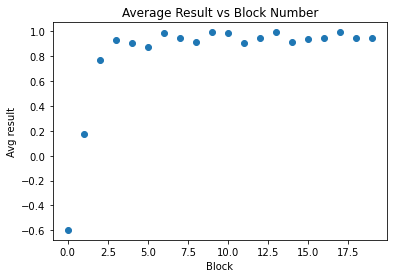

In [47]:
# ------------------- Structure #1 Q-Learning  -------------------
# ------------ Column above goal state

MDP_q_s1 = MDP_S1(4, states, terminal_states, -0.01,0.01, ['north','south','east','west','up','down'], 0.999)
print("Block Means")
block_means = []
learn = q_learn(MDP_q_s1,1000)[1]
start = 0
end = 50
while end <= len(learn):
    block_means.append(np.mean(learn[start:end]))
    start += 50
    end +=50
    
print(block_means)
print(" ")

y = [i for i in range(len(block_means))]
plt.scatter(y, block_means)
plt.xlabel("Block")
plt.ylabel("Avg result")
plt.title("Average Result vs Block Number")

Block Means:
[-1.5703322280882657, -0.015232025724573986, 0.48680918230045933, 0.8888076186753183, 0.8601209301952398, 0.9098236215877448, 0.8851620711500956, 0.7935313886807297, 0.8996158254655477, 0.8566741574214868, 0.8532445321716223, 0.8357599093609954, 0.8543731410123285, 0.8884610125328198, 0.8778598601577027, 0.8450192319574752, 0.900044667549202, 0.7927800457798017, 0.7908903372926217, 0.5588907807468879]
 


Text(0.5, 1.0, 'Average Result vs Block Number')

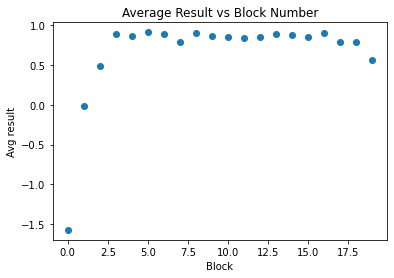

In [48]:
# ------------------- Structure #2 Q-Learning  -------------------
# ------------ Tree in state (1,3,z)

MDP_q_s2 = MDP_S2(4, states, terminal_states, -0.01, -0.5, ['north','south','east','west','up','down'], 0.999)
print("Block Means:")
block_means = []
learn = q_learn(MDP_q_s2,1000)[1]
start = 0
end = 50
while end <= len(learn):
    block_means.append(np.mean(learn[start:end]))
    start += 50
    end +=50
    
print(block_means)
print(" ")

y = [i for i in range(len(block_means))]
plt.scatter(y, block_means)
plt.xlabel("Block")
plt.ylabel("Avg result")
plt.title("Average Result vs Block Number")

Block Means:
[-1.0147238969852912, -0.8449317152646184, 0.7911874056111313, 0.8276008115246449, 0.9266398499805908, 0.9353014244438139, 0.8493203761914145, 0.852639318875162, 0.9011696631918636, 0.8957119112923742, 0.8474646619966052, 0.8507758010226866, 0.8553936204294774, 0.8935724653948854, 0.9385067827567348, 0.9342758098196984, 0.8971634725201395, 0.8598356372022363, 0.8948096886408478, 0.8497197726740815]
 


Text(0.5, 1.0, 'Average Result vs Block Number')

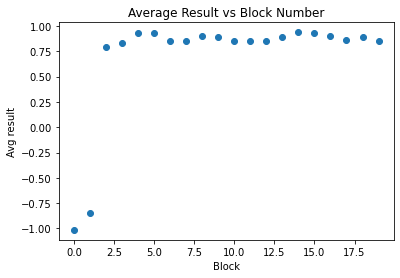

In [49]:
# ------------------- Structure #3 Q-Learning  -------------------
# ------------ Edges of cube have lower reward

MDP_q_s3 = MDP_S2(4, states, terminal_states, -0.01, -0.05, ['north','south','east','west','up','down'], 0.999)
block_means = []
learn = q_learn(MDP_q_s3,1000)[1]
start = 0
end = 50
while end <= len(learn):
    block_means.append(np.mean(learn[start:end]))
    start += 50
    end +=50
print("Block Means:")
print(block_means)
print(" ")

y = [i for i in range(len(block_means))]
plt.scatter(y, block_means)
plt.xlabel("Block")
plt.ylabel("Avg result")
plt.title("Average Result vs Block Number")

**Part F Explanation:**

*NOTE*: keep in mind that these results are for L=4

The first reward structure I created is that the terminal state (not goal) had a reward of -1, the goal of +1, the living reward of -0.01, and lastly that there is a "column" above the landing pad where its living reward is +0.01. While testing certain states with policy iteration, it returned the results I expected. The state (2,1,1) returned the policy 'north', which is important and happened exactly how it should have because it's the state right next to the goal column. Furthmore, looking at the plot of block means, it is seen that the drone learned extremely quickly due to those positive reward values in the middle column, and I expected this to happen. The means are around 1 near the end and it rapidly converged to that reward value. 

The second reward structure I created has an item, or a tree placed in the spot (1,3,z). The default living reward is -0.01, the goal +1, and the terminal states -1. However, if the drone hits the tree, it has a reward of -0.5 (so if it lands anywhere when x=1 and y=3 it will subtract reward of -0.5). While testing different states for policy iteration, all the states I used returned an expected policy, and the state (1,2,1) (right next to the tree) returned east, which is good because we want to avoid going south in the direction of the object and subtract the reward. The drone also learned very quickly when looking at the plot of block means for q-learning, which is what I expected, however its mean is slightly lower than the first reward structure. I expected this because instead of learning to go towards the center where the rewards are higher and knowing that the goal is at the bottom of the center column, it learns to just go away from the south side where the y is 1 or lower. 

Lastly, the third reward structure has the edges of the cube have a lower living reward with -0.05 (default is -0.01, goal is +1, and terminal is -1). I expected this to result almost exactly like how the original reward structure is since the drone learns to avoid going towards the edges where the direction is oposite of the center where the goal is. Doing policy iteration resulted in the same answers as the original reward structure, except with the added state of (1,1,1), which is right near the edge, and returned east. Furthermore, using q-learning, I expected the drone to learn just as rapidly as the original reward structure, and when comparing the two plots, it is confirmed that they looked almost exactly the same in terms of means and how fast it shot up to a converging rewards value.